In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

!unzip current_work.zip

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

def edge_detector(img_path):
  img = mpimg.imread(img_path)
  img1 = img/255
  img1 = img1.reshape((1,) + img.shape)
  img1 = tf.convert_to_tensor(img1)
  sobel = tf.image.sobel_edges(img1)
  sobel_x = np.asarray(sobel[0, :, :, :, 0])
  sobel_y = np.asarray(sobel[0, :, :, :, 1])
  plt.imshow(sobel_x)
  plt.imshow(sobel_y)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

train_gen = ImageDataGenerator(rescale = 1./255, rotation_range = 40, height_shift_range = 0.2,
                               width_shift_range = 0.2, zoom_range = 0.2, shear_range = 0.2, 
                               horizontal_flip = True, fill_mode = 'nearest')

training_generator = train_gen.flow_from_directory('...', target_size = (224, 224), batch_size = 14,
                                                   class_mode = 'categorical', color_mode = 'rgb')

test_gen = ImageDataGenerator(rescale = 1./255, rotation_range = 40,height_shift_range = 0.2,
                              width_shift_range = 0.2, zoom_range = 0.2, shear_range = 0.2,
                              horizontal_flip = 'True', fill_mode = 'nearest')

testing_generator = test_gen.flow_from_directory('...', target_size = (224, 224), batch_size = 4,
                                                 class_mode = 'categorical', color_mode = 'rgb')

Found 518 images belonging to 10 classes.
Found 96 images belonging to 10 classes.


In [5]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg = VGG16(input_shape = (224, 244, 3), weights = 'imagenet', include_top = False)
for layer in vgg.layers:
  layer.trainable = False

In [6]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 244, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 61, 128)       0     

In [7]:
import tensorflow as tf
from tensorflow.nn import relu, softmax
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback

class my_callback(Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('val_accuracy') >= 0.90:
      print('Stopping training, reached 90% validation accuracy!')
      self.model.stop_training = True
callback = my_callback()

x = Flatten()(vgg.output) 
x = Dense(1024, activation = relu)(x)
x = Dense(10, activation = softmax)(x)

model = Model(vgg.input, x)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')

In [8]:
history = model.fit_generator(training_generator, steps_per_epoch = 8, validation_data = testing_generator, 
                              validation_steps = 8, verbose = 1, epochs = 20, callbacks = [callback])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
8/8 [==============================] - 3s 318ms/step - loss: 12.6755 - accuracy: 0.1696 - val_loss: 7.4067 - val_accuracy: 0.0000e+00
Epoch 2/20
8/8 [==============================] - 2s 259ms/step - loss: 5.4577 - accuracy: 0.2054 - val_loss: 4.4104 - val_accuracy: 0.2188
Epoch 3/20
8/8 [==============================] - 2s 264ms/step - loss: 3.0453 - accuracy: 0.3750 - val_loss: 2.5406 - val_accuracy: 0.3125
Epoch 4/20
8/8 [==============================] - 2s 261ms/step - loss: 2.0561 - accuracy: 0.4375 - val_loss: 1.8548 - val_accuracy: 0.4375
Epoch 5/20
8/8 [==============================] - 2s 262ms/step - loss: 1.6157 - accuracy: 0.4821 - val_loss: 1.4182 - val_accuracy: 0.5938
Epoch 6/20
8/8 [==============================] - 2s 262ms/step - loss: 1.2645 - accuracy: 0.5536 - val_loss: 1.3422 - val_accuracy: 0.5625
Epoch 7/20
8/8 [==============================] - 2s 264ms/step - loss: 1.2619 

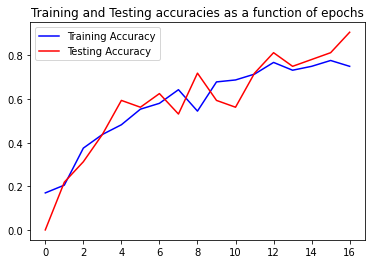

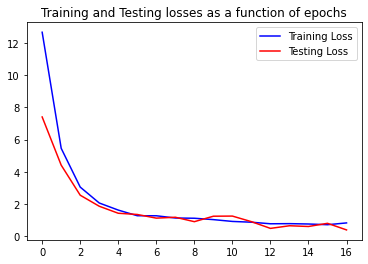

In [9]:
training_accuracy = history.history['accuracy']
testing_accuracy = history.history['val_accuracy']

epochs = range(len(training_accuracy))

plt.plot(epochs, training_accuracy, 'b', label = "Training Accuracy")
plt.plot(epochs, testing_accuracy, 'r', label = "Testing Accuracy")
plt.title('Training and Testing accuracies as a function of epochs')
plt.legend()

training_loss = history.history['loss']
testing_loss = history.history['val_loss']

plt.figure()
plt.plot(epochs, training_loss, 'b', label = "Training Loss")
plt.plot(epochs, testing_loss, 'r', label = "Testing Loss")
plt.title('Training and Testing losses as a function of epochs')
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


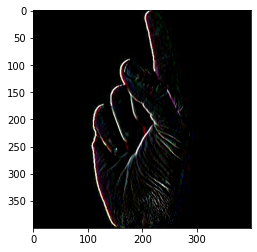

In [10]:
edge_detector('/content/work_data/test/1/hand1_1_bot_seg_4_cropped.jpeg')

In [11]:
model.save('/content/vgg_model_final.h5')